# Unsup for health records

* Idealization the methods for health records handling

In [15]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score, silhouette_score

## Dataset check

In [3]:
data_ori = pd.read_csv('C:/Users/user/Downloads/GNN_test.csv')
print("The shape of the original dataset is:", data_ori.shape)

The shape of the original dataset is: (152, 11)


In [4]:
data_ori.columns

Index(['E_No', 'Group', 'Age_V1', 'Sex_V1', 'living_V1', 'edu_yr_V1',
       'edu_gr_V1', 'marr_V1', 'job_V1', 'relig_V1', 'HAMD_total_V1'],
      dtype='object')

In [5]:
# 빈 문자열이나 공백을 NaN으로 변환
data_ori.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

In [6]:
print(data_ori.isnull().sum())

E_No             0
Group            0
Age_V1           0
Sex_V1           1
living_V1        1
edu_yr_V1        1
edu_gr_V1        1
marr_V1          1
job_V1           3
relig_V1         1
HAMD_total_V1    0
dtype: int64


In [7]:
data_ori = data_ori.dropna()

In [8]:
data_ori.shape

(149, 11)

In [9]:
data_ori.head()

,E_No,Group,Age_V1,Sex_V1,living_V1,edu_yr_V1,edu_gr_V1,marr_V1,job_V1,relig_V1,HAMD_total_V1
0,1,2,23,1,2,14,3,1,4,5,21
1,2,2,38,1,2,16,4,2,1,5,14
2,3,1,57,2,2,12,3,4,3,5,17
3,4,1,19,2,2,12,3,1,4,1,17
4,5,1,33,1,1,16,4,1,6,2,21


In [10]:
data_ori['Group'].value_counts()

Group
3    59
2    51
1    39
Name: count, dtype: int64

In [11]:
data_unsup = data_ori.copy()
data_unsup = data_unsup.drop(['E_No', 'HAMD_total_V1'], axis=1)
data_unsup['Group'] = (data_unsup['Group'] -1)
# data_unsup = data_unsup.drop(['E_No', 'Group'], axis=1)

In [12]:
data_unsup.head()

,Group,Age_V1,Sex_V1,living_V1,edu_yr_V1,edu_gr_V1,marr_V1,job_V1,relig_V1
0,1,23,1,2,14,3,1,4,5
1,1,38,1,2,16,4,2,1,5
2,0,57,2,2,12,3,4,3,5
3,0,19,2,2,12,3,1,4,1
4,0,33,1,1,16,4,1,6,2


In [13]:
data_y = data_unsup.loc[:, ['Group']]
data_x = data_unsup.drop(['Group'], axis=1)

In [ ]:
# x = data_x.copy()

# scaler = MinMaxScaler() #set the scaler (between 0 and 1)
# # scaler = RobustScaler()
# x[:] = scaler.fit_transform(x[:])
# x = x.round(decimals=6)

In [ ]:
# y = data_y.copy()
# # y = to_categorical(y, 3)

In [ ]:
# 그룹 변수를 분리
group_column = 'Group'
features = data_unsup.drop(columns=[group_column])  # Feature 데이터만 남김
true_labels = LabelEncoder().fit_transform(data_unsup[group_column])  # Group 변수를 숫자로 인코딩

## Unsupervised approaches

### K-means

In [ ]:
# K-means 클러스터링 적용
kmeans = KMeans(n_clusters=3, random_state=710674)
kmeans_labels = kmeans.fit_predict(data_x)

In [ ]:
kmeans_labels

In [ ]:
true_labels

In [ ]:
# 클러스터링 성능 평가
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)
silhouette_kmeans = silhouette_score(data_unsup, kmeans_labels)

print(f"K-means ARI: {ari_kmeans}")
print(f"K-means Silhouette Score: {silhouette_kmeans}")

### Gaussian Mixture (GMM)

In [ ]:
# Gaussian Mixture Model 적용
gmm = GaussianMixture(n_components=3, random_state=710674)
gmm_labels = gmm.fit_predict(data_x)

# 클러스터링 성능 평가
ari_gmm = adjusted_rand_score(true_labels, gmm_labels)
silhouette_gmm = silhouette_score(data_x, gmm_labels)

print(f"GMM ARI: {ari_gmm}")
print(f"GMM Silhouette Score: {silhouette_gmm}")

### Autoencoder

In [ ]:
data.shape

In [ ]:
# Autoencoder 모델 생성
data = data_x

input_dim = data.shape[1]
encoding_dim = 3  # 저차원 공간으로 축소할 차원 수

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Autoencoder 학습
autoencoder.fit(data, data, epochs=50, batch_size=10, shuffle=True, verbose=2)

# 축소된 차원으로 데이터 변환
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(data)

# K-means를 사용하여 Autoencoder의 출력으로 클러스터링
kmeans_encoded = KMeans(n_clusters=3, random_state=710674)
kmeans_encoded_labels = kmeans_encoded.fit_predict(encoded_data)

# 클러스터링 성능 평가
ari_autoencoder = adjusted_rand_score(true_labels, kmeans_encoded_labels)
silhouette_autoencoder = silhouette_score(encoded_data, kmeans_encoded_labels)

print(f"Autoencoder K-means ARI: {ari_autoencoder}")
print(f"Autoencoder K-means Silhouette Score: {silhouette_autoencoder}")

In [18]:
data_unsup

,Group,Age_V1,Sex_V1,living_V1,edu_yr_V1,edu_gr_V1,marr_V1,job_V1,relig_V1
0,1,23,1,2,14,3,1,4,5
1,1,38,1,2,16,4,2,1,5
2,0,57,2,2,12,3,4,3,5
3,0,19,2,2,12,3,1,4,1
4,0,33,1,1,16,4,1,6,2
...,...,...,...,...,...,...,...,...,...
147,1,21,2,1,12,3,1,4,5
148,0,64,2,1,12,3,2,3,1
149,2,21,2,1,12,3,1,4,5
150,2,40,2,1,12,3,2,3,1


C:\Users\user\anaconda3\envs\medical2\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


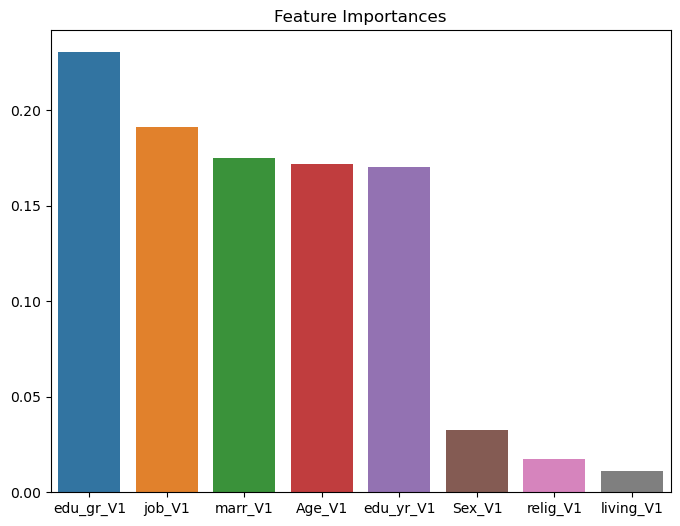

In [22]:
X = data_x.copy()
y = data_y.copy()
df = data_unsup.copy()

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 군집화 수행 (질병군 내에서)
kmeans = KMeans(n_clusters=3, random_state=42)  # 예시로 3개의 군집
df['Group'] = kmeans.fit_predict(X_scaled)

# 3. 변수 중요도 평가 - 랜덤 포레스트를 사용하여 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(X, df['Group'])

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns[indices], y=importances[indices])
plt.title('Feature Importances')
plt.show()